In [1]:
import json
import pandas as pd
import scipy.stats

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
blue = '#1f77b4'
light_blue = '#aec7e8'
orange = '#ff7f0e'
light_orange = '#ffbb78'
gray = '#60636a'
light_gray = '#a5acaf'

Create a new folder called `figures` before

# Load the tweets and bot scores

In [5]:
def load_json_objects(path_to_file):
    """
    Function to load JSON objects from .jsons file.
    Each line of the .jsons file should be a serialized JSON object 
    """
    json_objects = []
    with open(path_to_file) as f:
        for line in f:
            json_object = json.loads(line)
            json_objects.append(json_object)
    return json_objects

In [6]:
shib_tweets = load_json_objects("../data/shib_tweets.jsons")
shib_bot_scores = load_json_objects("../data/shib_bot_scores.jsons")

In [7]:
floki_tweets = load_json_objects("../data/floki_tweets.jsons")
floki_bot_scores = load_json_objects("../data/floki_bot_scores.jsons")

In [8]:
aapl_tweets = load_json_objects("../data/aapl_tweets.jsons")
aapl_bot_scores = load_json_objects("../data/aapl_bot_scores.jsons")

# Process the tweets and bot scores

Extract the tweet id and user id of each tweet

In [9]:
tweet_info = []
for tweet in shib_tweets:
    tweet_info.append([
        tweet['id_str'],
        tweet['user']['id_str'],
        'shib'
    ])

for tweet in floki_tweets:
    tweet_info.append([
        tweet['id_str'],
        tweet['user']['id_str'],
        'floki'
    ])
    
for tweet in aapl_tweets:
    tweet_info.append([
        tweet['id_str'],
        tweet['user']['id_str'],
        'aapl'
    ])

tweet_info_df = pd.DataFrame(tweet_info, columns=['tid', 'user_id', 'cashtag'])

Extract the bot scores of the accounts 

In [10]:
bot_scores = []
for bot_score in shib_bot_scores:
    bot_scores.append([
        bot_score['user']['user_data']['id_str'],
        bot_score['user']['majority_lang'],
        bot_score['raw_scores']['english']['overall'],
        bot_score['raw_scores']['universal']['overall']
    ])
    
for bot_score in floki_bot_scores:
    bot_scores.append([
        bot_score['user']['user_data']['id_str'],
        bot_score['user']['majority_lang'],
        bot_score['raw_scores']['english']['overall'],
        bot_score['raw_scores']['universal']['overall']
    ])
    

for bot_score in aapl_bot_scores:
    bot_scores.append([
        bot_score['user']['user_data']['id_str'],
        bot_score['user']['majority_lang'],
        bot_score['raw_scores']['english']['overall'],
        bot_score['raw_scores']['universal']['overall']
    ])
    
bot_scores_df = pd.DataFrame(bot_scores, columns=['user_id', 'lang', 'eng', 'uni'])

Remove duplicates

In [11]:
bot_scores_df.drop_duplicates(subset=['user_id'], inplace=True)

Merge the tweet information with bot scores

In [12]:
tweet_with_bot_score_df = tweet_info_df.merge(bot_scores_df, on='user_id')

# Analyze the data

## Check the number of tweets and unique users

In [13]:
tweet_info_df.groupby("cashtag").agg({
    'tid': 'nunique',
    'user_id': 'nunique'
})

,tid,user_id
cashtag,,
aapl,2000,1107
floki,2000,937
shib,2000,1241


## Check the use of different languages

In [14]:
lang_freq = bot_scores_df.lang.value_counts()

In [15]:
lang_code_map = {
    'en': "English",
    'ja': "Japanese",
    'und': "Unknown",
    'es': "Spanish",
    'tr': "Turkish",
    'ar': "Arabic",
    'fr': "French",
    'in': "Hindi",
    'pt': "Portuguese",
    'it': "Italian"
}

In [16]:
lang_labels = []
lang_freq_count = []
for index, freq in lang_freq.head(6).iteritems():
    lang_labels.append(f"{lang_code_map.get(index)} ({freq / lang_freq.sum()*100:.1f}%)")
    lang_freq_count.append(freq)
    
lang_labels.append(f"Others ({lang_freq.tail(-6).sum() / lang_freq.sum()*100:.1f}%)")
lang_freq_count.append(lang_freq.tail(-6).sum())

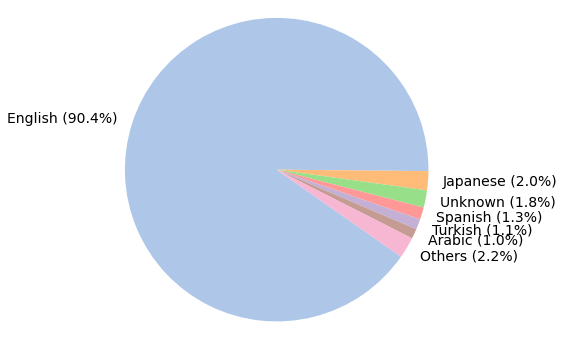

In [17]:
plt.figure(figsize=(6, 6))
colors = [
    "#aec7e8",
    "#ffbb78",
    "#98df8a",
    "#ff9896",
    "#c5b0d5",
    "#c49c94",
    "#f7b6d2",
]
plt.pie(
    lang_freq_count,
    labels=lang_labels,
    colors=colors,
    counterclock=False,
    startangle=-35)
plt.gca().axis('equal');
plt.savefig("figures/language_freqency.pdf")

In [18]:
analytical_sample = tweet_with_bot_score_df.query('lang == "en"')

In [19]:
analytical_sample.groupby("cashtag").agg({
    'tid': 'nunique',
    'user_id': 'nunique'
})

,tid,user_id
cashtag,,
aapl,1864,1006
floki,1893,860
shib,1819,1111


## Check the bot score distribution

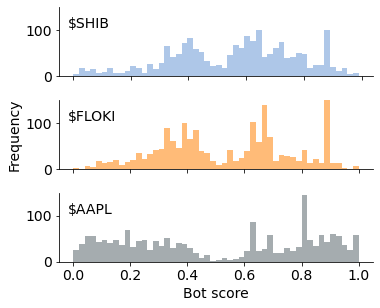

In [20]:
dist_to_plot = [
    [1, 'shib', light_blue, '$SHIB'],
    [2, 'floki', light_orange, '$FLOKI'],
    [3, 'aapl', light_gray, '$AAPL']
]

plt.figure(figsize=(5.5, 4.5))
for index, key, color, title in dist_to_plot:
    plt.subplot(3, 1, index)
    plt.hist(
        analytical_sample.query(f'cashtag == "{key}"').eng,
        bins=50,
        color=color,
    );
    plt.annotate(title, xy=(0.03,0.7), xycoords='axes fraction')
    if index<3:
        plt.gca().set_xticklabels([])
    if index == 2:
        plt.ylabel("Frequency")
    if index==3:
        plt.xlabel('Bot score')
        
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.ylim([0, 150])
plt.tight_layout()
plt.savefig("figures/bot_score_dist.pdf")

## Boxplot

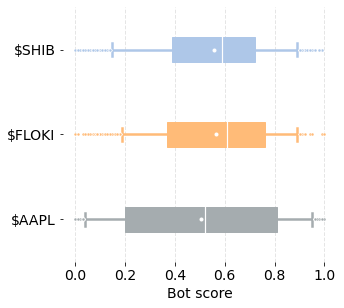

In [21]:
plt.figure(figsize=(5, 4.5))
for index, key, color, title in dist_to_plot:
    box = plt.boxplot(
        [
            analytical_sample.query(f'cashtag == "{key}"').eng
        ],
        positions=[4 - index],
        widths=0.3,
        patch_artist=True,
        notch=False,
        whis=(5, 95),
        vert=False,
        showmeans=True
    );
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box[item], color=color)
    plt.setp(box['medians'], color='white', lw=1.2)
    plt.setp(box["boxes"], facecolor=color)
    plt.setp(box["fliers"], markerfacecolor=color, markeredgecolor='white', markersize=3, markeredgewidth=0.5)
    plt.setp(box['whiskers'], lw=2.5)
    plt.setp(box['caps'], lw=2.5)
    plt.setp(box['means'], marker='o', markerfacecolor='white', markeredgecolor='white', markersize=3)
plt.gca().xaxis.grid(which="major", color='gray', linestyle='--', linewidth=1, alpha=0.2)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.yticks([3, 2, 1], ['$SHIB', '$FLOKI', '$AAPL'])
plt.xlabel('Bot score')

plt.tight_layout()
plt.savefig("figures/bot_score_boxplot.pdf")

In [22]:
scipy.stats.mannwhitneyu(
    analytical_sample.query('cashtag == "shib"').eng,
    analytical_sample.query('cashtag == "floki"').eng
)

MannwhitneyuResult(statistic=1702837.0, pvalue=0.5634052283695281)

In [23]:
scipy.stats.mannwhitneyu(
    analytical_sample.query('cashtag == "shib"').eng,
    analytical_sample.query('cashtag == "aapl"').eng
)

MannwhitneyuResult(statistic=1828118.0, pvalue=3.840825579506417e-05)

In [24]:
scipy.stats.mannwhitneyu(
    analytical_sample.query('cashtag == "floki"').eng,
    analytical_sample.query('cashtag == "aapl"').eng
)

MannwhitneyuResult(statistic=1964076.0, pvalue=1.82226713091619e-09)

## Different thresholds

In [25]:
shib_tweet_count = len(analytical_sample.query('cashtag == "shib"'))
floki_tweet_count = len(analytical_sample.query('cashtag == "floki"'))
aapl_tweet_count = len(analytical_sample.query('cashtag == "aapl"'))

In [26]:
shib_tweet_count

1819

In [27]:
print(
    len(analytical_sample.query('cashtag == "shib" and eng > 0.5')),
    len(analytical_sample.query('cashtag == "shib" and eng > 0.7'))
)

1098 524


In [28]:
floki_tweet_count

1893

In [29]:
print(
    len(analytical_sample.query('cashtag == "floki" and eng > 0.5')),
    len(analytical_sample.query('cashtag == "floki" and eng > 0.7'))
)

1061 557


In [30]:
aapl_tweet_count

1864

In [31]:
print(
    len(analytical_sample.query('cashtag == "aapl" and eng > 0.5')),
    len(analytical_sample.query('cashtag == "aapl" and eng > 0.7'))
)

936 688


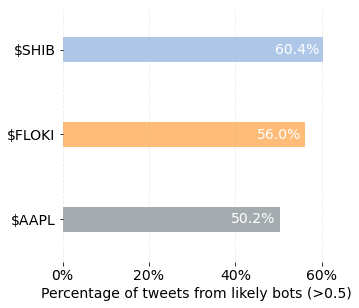

In [32]:
plt.figure(figsize=(5, 4.5))
threshold = 0.5
bot_pct = [
    len(analytical_sample.query(f'cashtag == "shib" and eng > {threshold}')) / shib_tweet_count,
    len(analytical_sample.query(f'cashtag == "floki" and eng > {threshold}')) / floki_tweet_count,
    len(analytical_sample.query(f'cashtag == "aapl" and eng > {threshold}')) / aapl_tweet_count
]
plt.barh(
    [3, 2, 1],
    bot_pct,
    height=0.3,
    color=[light_blue, light_orange, light_gray]
)

for i, pct in enumerate(bot_pct):
    plt.text(pct-0.06, 3 - i, f"{pct*100:.1f}%", color='white', ha='center', va='center')

plt.ylim([0.5, 3.5])
plt.xlim([0, 0.62])

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.gca().grid(axis='x', alpha=0.2, linestyle='--', linewidth=1,)

plt.yticks([3, 2, 1], ['$SHIB', '$FLOKI', '$AAPL'])
plt.xlabel(f"Percentage of tweets from likely bots (>{threshold})")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig("figures/bot_percent_05.pdf")

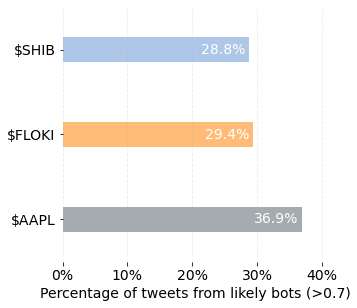

In [33]:
plt.figure(figsize=(5, 4.5))
threshold = 0.7
bot_pct = [
    len(analytical_sample.query(f'cashtag == "shib" and eng > {threshold}')) / shib_tweet_count,
    len(analytical_sample.query(f'cashtag == "floki" and eng > {threshold}')) / floki_tweet_count,
    len(analytical_sample.query(f'cashtag == "aapl" and eng > {threshold}')) / aapl_tweet_count
]
plt.barh(
    [3, 2, 1],
    bot_pct,
    height=0.3,
    color=[light_blue, light_orange, light_gray]
)

for i, pct in enumerate(bot_pct):
    plt.text(pct-0.04, 3 - i, f"{pct*100:.1f}%", color='white', ha='center', va='center')

plt.ylim([0.5, 3.5])
plt.xlim([0, 0.41])

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

plt.gca().grid(axis='x', alpha=0.2, linestyle='--', linewidth=1,)

plt.yticks([3, 2, 1], ['$SHIB', '$FLOKI', '$AAPL'])
plt.xlabel(f"Percentage of tweets from likely bots (>{threshold})")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig("figures/bot_percent_07.pdf")